In [350]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from tqdm import tqdm
from IPython.display import Image
import seaborn as sns
import calmap
from datetime import datetime, timedelta
import math
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RandomForest
from sklearn.tree import DecisionTreeRegressor as DecisionTree
from sklearn.ensemble import GradientBoostingRegressor as GradientBoosting
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
pd.options.mode.chained_assignment = None

In [34]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# M5 Forecasting - Accuracy
Vladislav Molodtsov, Irina Shushpannikova

https://www.kaggle.com/c/m5-forecasting-accuracy/data

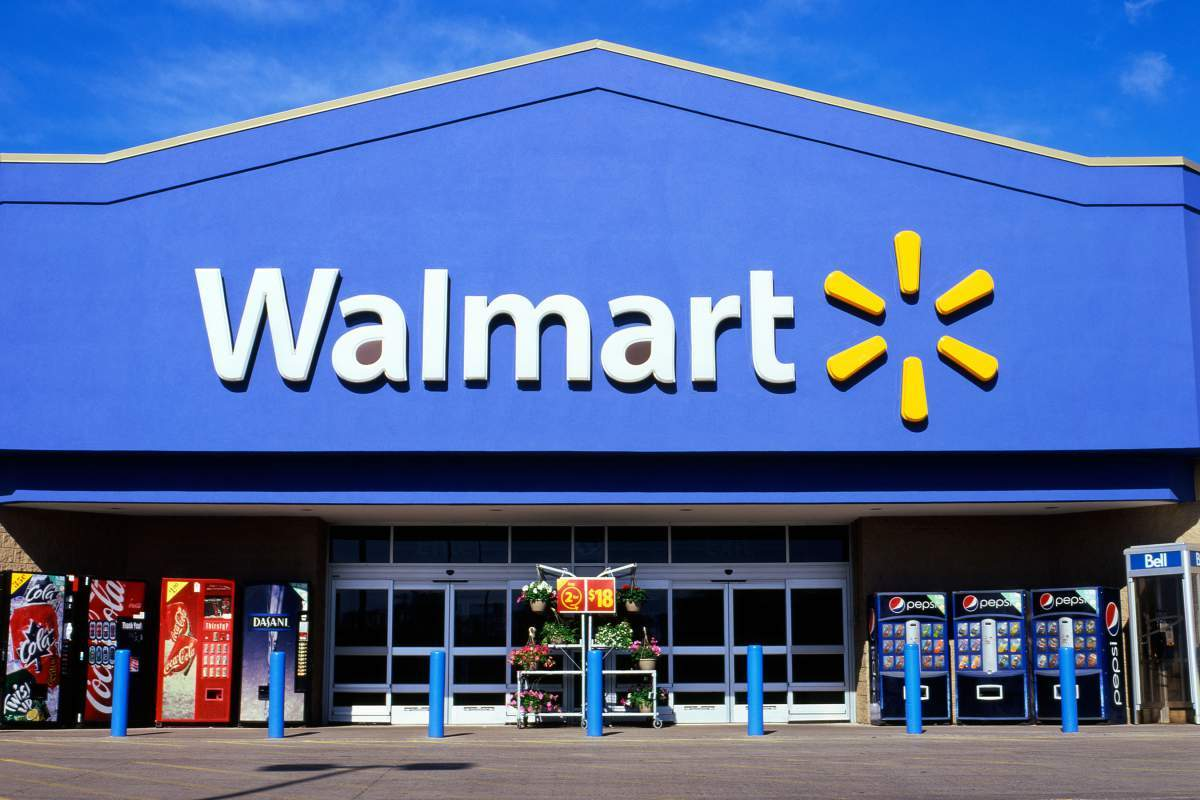

In [3]:
Image(filename='pics/view.jpg')

# Data exploration

### Available data:
* *sales_train_validation.csv* - daily sales
* *calendar.csv* - dates, holidays, discounts
* *sell_prices.csv* - commodity prices

In [5]:
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sell_prices = pd.read_csv('sell_prices.csv')

In [6]:
sales_train_validation.iloc[:12,:12]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,0,4
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,0,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,0,0


In [7]:
calendar = pd.read_csv('calendar.csv')
date=calendar.loc[:,['d','date']]
date.set_index('d', inplace=True)
date=date.reset_index(drop=True)
calendar.drop(index=np.arange(len(calendar)-1,len(calendar)-57, -1), inplace=True)

In [7]:
calendar.iloc[2:10,:]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [8]:
products_to_analyze = [
    'FOODS_1_006_CA_1_validation',
    'FOODS_1_016_CA_1_validation',
    'FOODS_1_018_CA_1_validation',
    'FOODS_1_024_CA_1_validation',
    'FOODS_1_054_CA_1_validation'
]

In [9]:
products_sales = list()
for i, product in enumerate(products_to_analyze):
    df = pd.DataFrame(sales_train_validation[sales_train_validation.id == product].iloc[0])
    df = df.drop(axis=0, labels=['id','item_id','dept_id','cat_id','store_id','state_id'])
    df = df.reset_index(drop=True)
    df.columns = ["sales"]
    df.sales = df.sales.astype('int')

    df=pd.concat([df,date],axis=1)
    df.dropna(inplace=True)
    df['date']=pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    products_sales.append(df)

In [10]:
def plot_data(product, name="Product 1", limits=[1,-1]):
    fig, ax = plt.subplots(figsize=(12,6))
    product.iloc[limits[0]:limits[1]].plot(title=name, fontsize=15, legend=False, ax=ax)

    ax.set_ylabel('Sales', size=25)
    ax.title.set_size(30)

    plt.show()

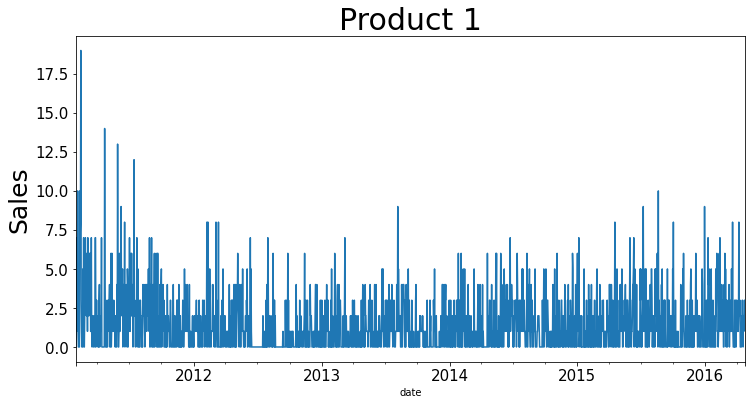

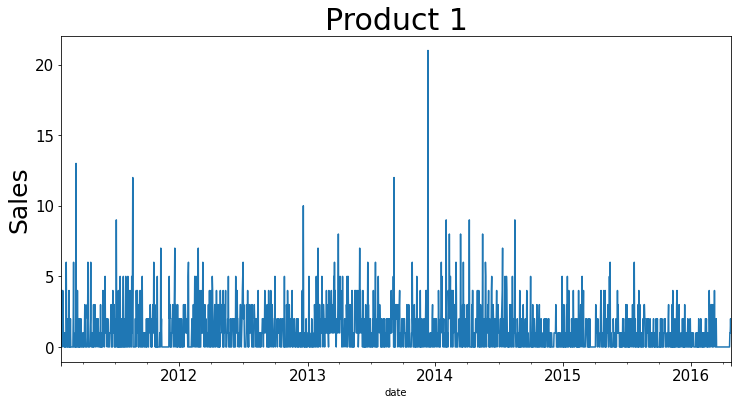

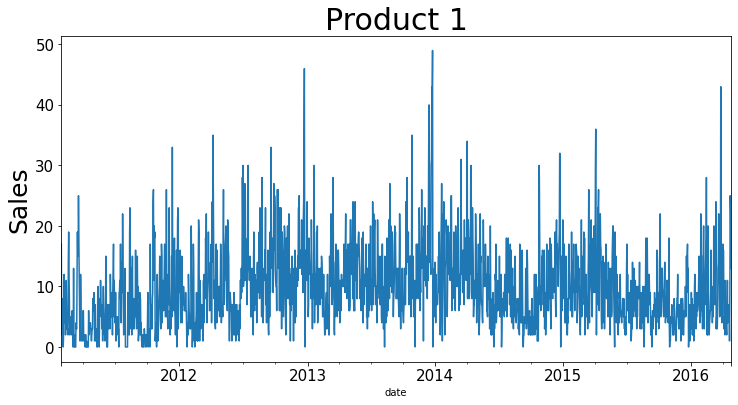

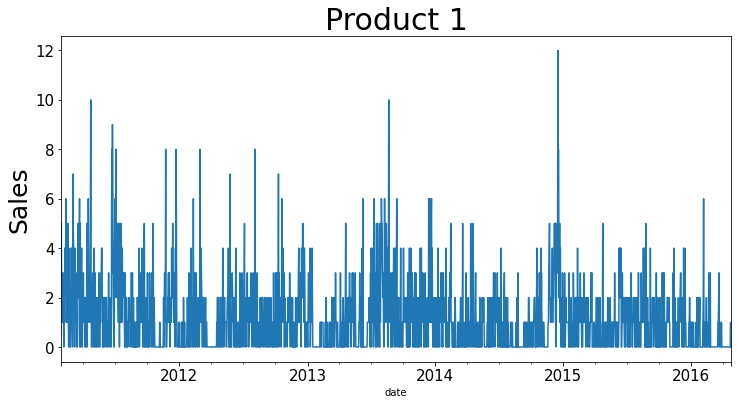

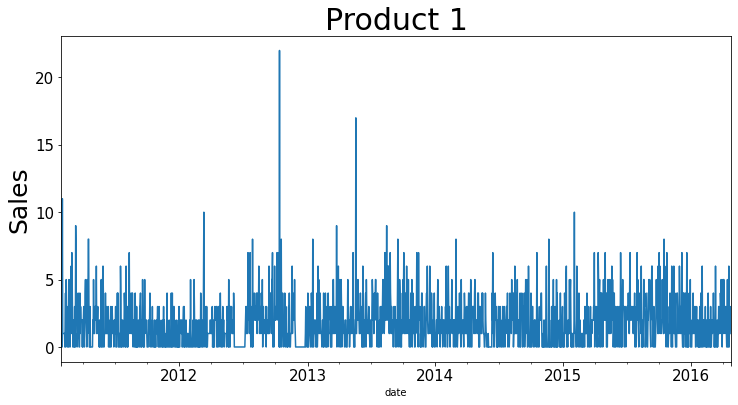

In [63]:
for product in products_sales:
    plot_data(product, "Product "+str(i+1))

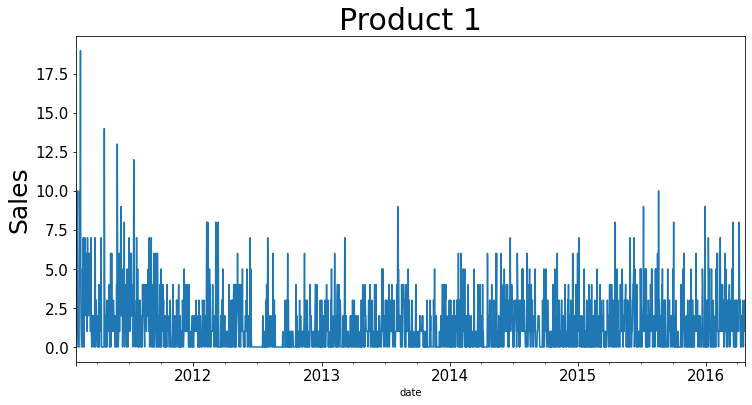

In [79]:
plot_data(products_sales[0], limits=[1,-1])

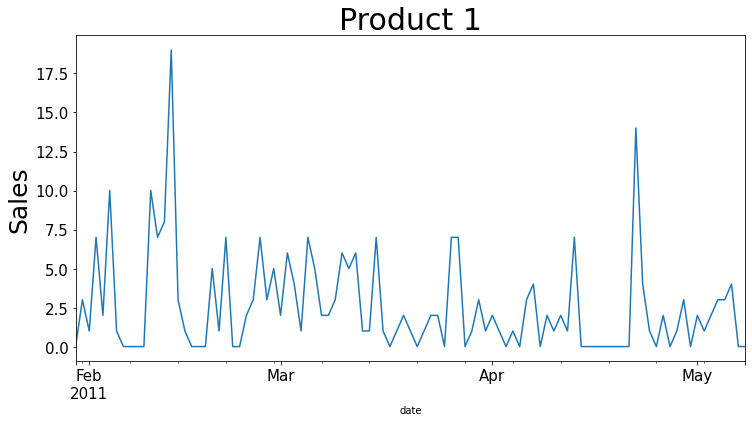

In [80]:
plot_data(products_sales[0], limits=[1,100])

In [13]:
def calendar_sales(number):
    year=2015
    n_graphs = min(number,len(data))
    fig, axes = plt.subplots(nrows=n_graphs, figsize=(16,12))
    
    for i in range(n_graphs):
        calmap.yearplot(data[i].sales, year=year, ax=axes[i])
        axes[i].yaxis.set_tick_params(labelsize=15)
        axes[i].xaxis.set_tick_params(labelsize=15)
        axes[i].set_title('Sales of Product '+str(i), fontdict={'fontsize':30})

    plt.tight_layout()
    plt.show()

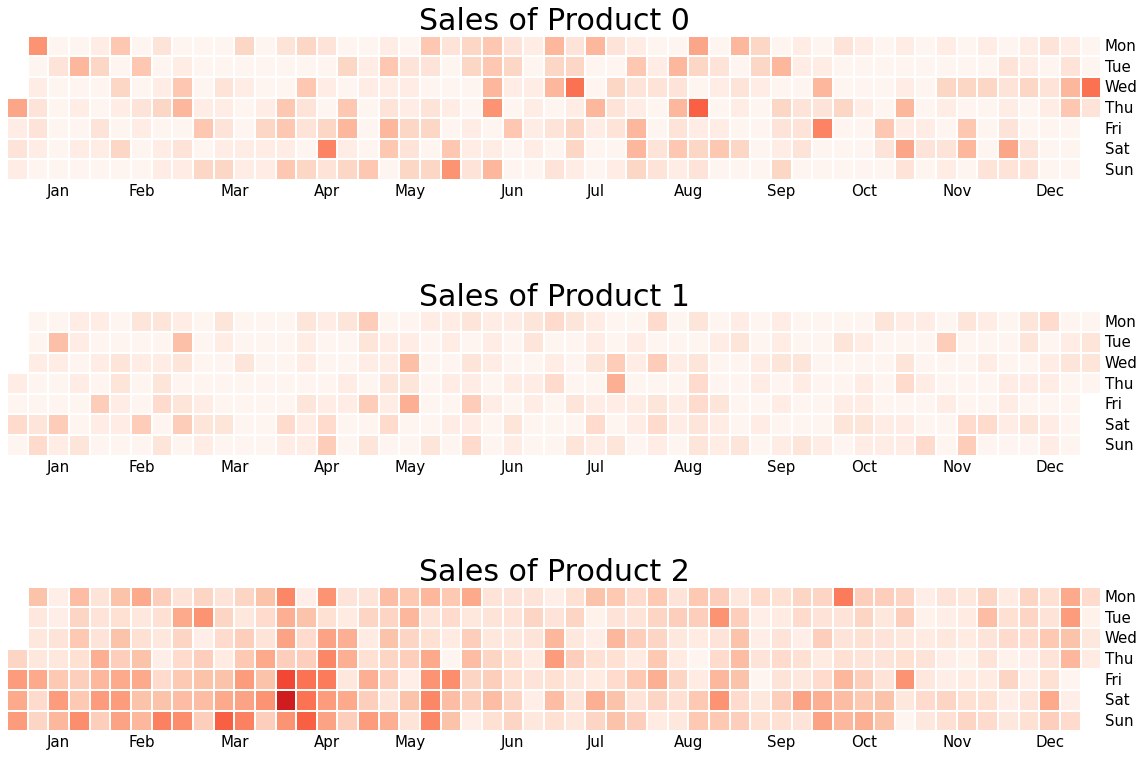

In [14]:
calendar_sales(3)

# Problem formulation

### Prediction of the next 28 days of sales - *Time Series Forecasting*

In [267]:
def add_lags_for_sales(dataframe, lags, drop=True):
    columns = list()
    
    for lag in lags:
        shifted = dataframe.sales.shift(lag)
        shifted.name = 'lag_'+str(lag)
        columns.append(shifted)
        
    concatenated = pd.concat([dataframe, *columns], axis=1)
    if drop:
        return concatenated.dropna()
    else:
        return concatenated

In [168]:
def add_lags_for_sales_list(series_list, lags):
    series_with_lags_list = list()

    for series in series_list:
        series_with_lags_list.append(add_lags_for_sales(series, lags))
        
    return series_with_lags_list

In [127]:
def list_train_test_split(data_list):
    i = 0
    train_list=[]
    test_list=[]
    
    for data in data_list:
        train, test = train_test_split(data, shuffle=False, test_size=1.45/100)
        train_list.append(train)
        test_list.append(test)
    return train_list, test_list

In [97]:
def split_to_features_target_list(series_with_lags_list):
    features_list=[]
    target_list=[]
    
    for series_with_lags in series_with_lags_list:
        features_list.append(series_with_lags.drop('sales', axis=1))
        target_list.append(series_with_lags['sales'])
        
    return features_list, target_list

In [118]:
def choose_best_parameters(model, param_search, features_train, target_train):    
    cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=8).split(features_train)] 

    gsearch = GridSearchCV(estimator=model, cv=cv,
                           param_grid=param_search, scoring='neg_mean_squared_error', n_jobs=-1, 
                           refit=True, return_train_score=True)

    gsearch.fit(features_train, target_train)

    return gsearch

In [119]:
def fit_optimal_model(model, param_search, features_train, target_train):
    best =  choose_best_parameters(model, param_search, features_train, target_train)
    metric = str(round(np.sqrt(mse(target_train, best.predict(features_train))),3))

    return best.best_estimator_, metric

In [121]:
def fit_optimal_model_for_data_list(model, grid, features_train_list, target_train_list):
    
    best_models_list = list()
    metrics = list()
    
    for features_train, target_train in zip(features_train_list, target_train_list):
        best_models, metric = fit_optimal_model(model, grid, features_train, target_train)
        best_models_list.append(best_models)
        metrics.append(metric)
     
    return best_models_list, metrics

In [152]:
def create_columns_name(metrics_list):
    i=0
    columns=[]
    new_column_name=""
    
    for i in range(int(size(metrics_list)/len(metrics_list))):
        new_column_name = "Product "+ str(i+1)
        columns.append(new_column_name)
    
    return columns


def print_metrics(metrics_list, model_lists_name, message):
    columns = create_columns_name(metrics_list)
    index = [str(x)[:-11] for x in model_lists_name]
    
    print(message)
    display(pd.DataFrame(metrics_list, index, columns))

In [384]:
def compute_test_metric(model, train_data, features_test, target_test):
    predicted = predict_future(model, train_data, features_test, target_test)
    return round(np.sqrt(mse(predicted, target_test)), 3)

def predict_future(model, train_data, features_test, target_test):
    date_to_predict_list = target_test.index

    for date_to_predict in date_to_predict_list:
        features_for_date_to_predict = features_test[features_test.index == date_to_predict]

        train_data_with_new_date = pd.concat([train_data,features_for_date_to_predict], axis=0)
        train_data_with_new_date_and_lags = add_lags_for_sales(train_data_with_new_date, lags, drop=False)
        new_features = train_data_with_new_date_and_lags.drop(labels=['sales'], axis=1).dropna()
        features_for_predict = new_features[new_features.index == date_to_predict]
        prediction = model.predict(features_for_predict)[0]
        features_for_predict['sales'] = prediction
        train_data = pd.concat([train_data, features_for_predict], axis=0).dropna(axis=1)

    return train_data.iloc[-28:].sales

In [382]:
def compute_test_metrics_for_data_list(model, train_data_list, test_data_list):
    metrics = list()
    
    features_test_list, target_test_list = split_to_features_target_list(test_data_list)

    for i, _ in enumerate(train_data_list):
        metric = compute_test_metric(model[i], train_data_list[i], features_test_list[i], target_test_list[i])
        metrics.append(metric)
     
    return metrics

In [379]:
def model_lists_f(model_lists_name, models_grids, data_list, lags):
    train_data_list, test_data_list = list_train_test_split(data_list)
    train_data_with_lags_list = add_lags_for_sales_list(train_data_list, lags)    

    best_models_list = []
    metrics_train_list = []

    features_train_list, target_train_list = split_to_features_target_list(train_data_with_lags_list)
    
    # Train all models for all data
    for i, model in enumerate(model_lists_name):
        # Train single model for all data and compute metric for that on all data
        best_models, metrics_train = fit_optimal_model_for_data_list(model, models_grids[i], \
                                                       features_train_list, target_train_list)
        best_models_list.append(best_models)
        metrics_train_list.append(metrics_train)
        
    print_metrics(metrics_train_list, model_lists_name, "RMSE metric of fitting on train")
    
    metrics_test_list = []
    
    # Predict by all models for all data
    for best_model in best_models_list:
        # Predict by single model for all data
        metrics_test = compute_test_metrics_for_data_list(best_model, train_data_list, test_data_list)
        metrics_test_list.append(metrics_test)
        
    print_metrics(metrics_test_list, model_lists_name, "RMSE metric of prediction for test")
    
    return best_models_list

In [388]:
model_lists = [DecisionTree(), RandomForest(), GradientBoosting()]
model_grids = [
       
    {'max_depth' : range(1,4)},
   
    {'n_estimators' : range(1,10)},

    {'max_depth': range(1,3)}
    
              ]
lags = [1,2,3,4,5,6,7]

In [389]:
best_models_list = model_lists_f(model_lists, model_grids, products_sales, lags)

RMSE metric of fitting on train


,Product 1,Product 2,Product 3,Product 4,Product 5
DecisionTree,1.829,1.609,5.798,1.377,1.81
RandomForest,0.974,0.924,2.725,0.728,0.832
GradientBoosting,1.81,1.594,5.427,1.357,1.771


RMSE metric of prediction for test


,Product 1,Product 2,Product 3,Product 4,Product 5
DecisionTree,1.599,1.133,7.287,1.166,1.750
RandomForest,1.785,0.481,7.013,1.105,1.961
GradientBoosting,1.623,1.121,7.146,1.046,1.726


In [406]:
def fittingShow(best_models, data_list, lags, index=0):
    model = best_models[index]
    
    train_data_list, _ = list_train_test_split(data_list)
    train_data_with_lags_list = add_lags_list(train_data_list, lags)
    features_train_list, target_train_list = split_to_features_target_list(train_data_with_lags_list)    
    
    features_train = features_train_list[index]
    target_train = target_train_list[index]
    
    pred = model.predict(features_train)
    pred = pd.DataFrame(pred).set_index(target_train.index)[0]

    fig, axes = plt.subplots(figsize=(12,7))

    axes.set_title("Fitting by "+str(model).split('(')[0][:-9], \
                   fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes.yaxis.set_tick_params(labelsize=labelsize)
    axes.xaxis.set_tick_params(labelsize=labelsize)

    ind = np.arange(100,400)
    target_train[ind].plot(ax=axes)
    pred[ind].plot(ax=axes,color='r', alpha=0.7)

    axes.set_ylabel("Product "+str(index+1)+" sales", fontsize=25)
    axes.set_xlabel('Date', fontsize=25)

    axes.legend(['Observed', 'Fitted'], fontsize=20, loc='upper right')

    plt.tight_layout()
    plt.show()
    
    print('RMSE: %.5f' % np.sqrt(mse(target_train, pred)))

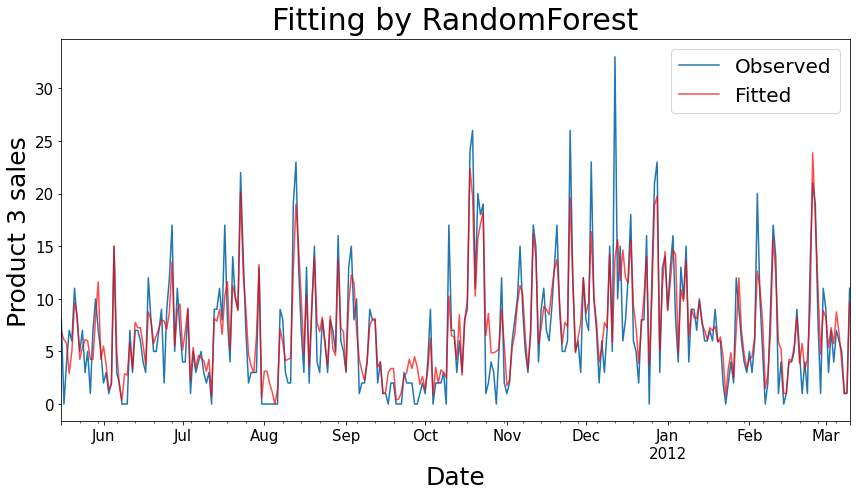

RMSE: 2.72451


In [470]:
fittingShow(best_models_list[1], products_sales, lags, index=2)

In [475]:
def estimationShow(best_models, data_list, lags, index=0):
    model = best_models[index]
    
    train_data_list, test_data_list = list_train_test_split(data_list)
    train_data = train_data_list[index]
    
    features_test_list, target_test_list = split_to_features_target_list(test_data_list)    
    features_test = features_test_list[index]
    target_test = target_test_list[index]
    
    pred = predict_future(model, train_data, features_test, target_test)
    pred = pd.concat([train_data[train_data.index == train_data.index[-1]].sales, pred], axis=0)

    fig, axes = plt.subplots(figsize=(12,7))

    train_data.sales[-1000:].plot(ax=axes)
    pred.plot(ax=axes,color='r', alpha=0.7)

    
    axes.set_title("Prediction by "+str(model).split('(')[0][:-9], \
               fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes.yaxis.set_tick_params(labelsize=labelsize)
    axes.xaxis.set_tick_params(labelsize=labelsize)

    axes.set_ylabel("Product "+str(index+1)+" sales", fontsize=25)
    axes.set_xlabel('Date', fontsize=25)

    axes.legend(['Observed','Predicted'], fontsize=20, loc='upper right')
        
    plt.tight_layout()
    plt.show()

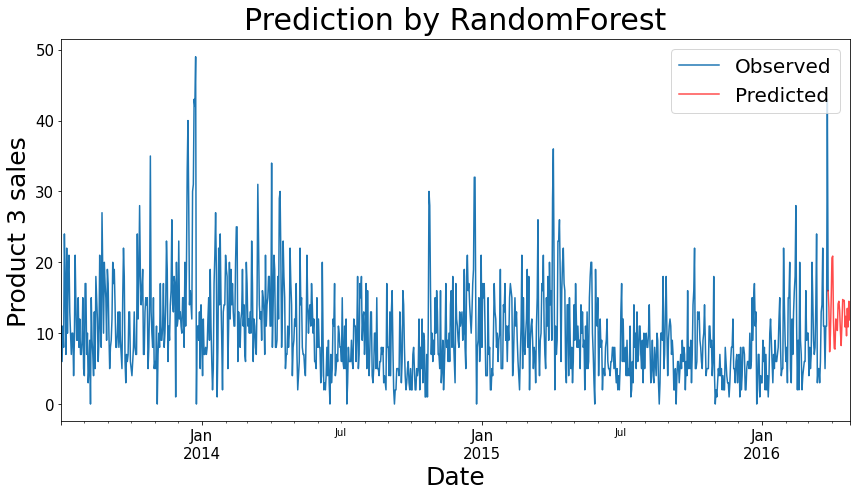

In [476]:
estimationShow(best_models_list[1], products_sales, lags, index=2)

In [483]:
def estimationCompare(best_models, data_list, lags, index=0):
    model = best_models[index]
    
    train_data_list, test_data_list = list_train_test_split(data_list)
    train_data = train_data_list[index]
    
    features_test_list, target_test_list = split_to_features_target_list(test_data_list)    
    features_test = features_test_list[index]
    target_test = target_test_list[index]
    
    pred = predict_future(model, train_data, features_test, target_test)
    pred_with_zero_day = pd.concat([train_data[train_data.index == train_data.index[-1]].sales, pred], axis=0)
    target_test_with_zero_day = pd.concat([train_data[train_data.index == train_data.index[-1]].sales, \
                                           target_test], axis=0)
    
    fig, axes = plt.subplots(figsize=(12,7))

    train_data.sales[-100:].plot(ax=axes)
    pred_with_zero_day.plot(ax=axes,color='r', alpha=0.7)
    target_test_with_zero_day.plot(color='g')

    axes.set_title("Prediction by "+str(model).split('(')[0][:-9], \
               fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes.yaxis.set_tick_params(labelsize=labelsize)
    axes.xaxis.set_tick_params(labelsize=labelsize)

    axes.set_ylabel("Product "+str(index+1)+" sales", fontsize=25)
    axes.set_xlabel('Date', fontsize=25)

    axes.legend(['Observed','Predicted', 'Test'], fontsize=20, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print('RMSE: %.5f' % np.sqrt(mse(target_test, pred)))

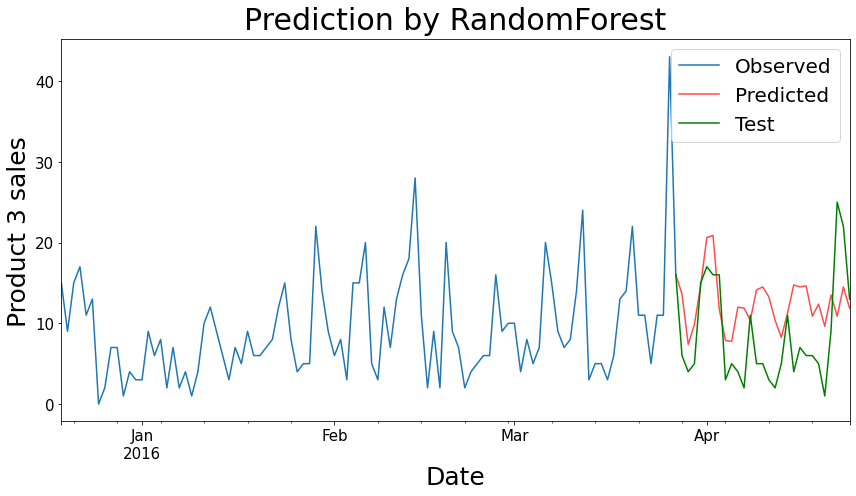

RMSE: 7.01278


In [484]:
estimationCompare(best_models_list[1], products_sales, lags, index=2)

# Residues observation

In [ ]:
def residues(model, title, pad):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

    axes[0].set_title(title, fontdict={'fontsize':30}, pad=20)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    (model.resid/1000).plot(ax=axes[0], legend=False)
    sm.graphics.tsa.plot_acf(model.resid.values.squeeze(), lags=800, ax=axes[1], markersize=4, title='')

    ylabelsize=20
    axes[0].set_ylabel('Residue, k', fontsize=ylabelsize, labelpad=pad[0])
    axes[0].set_xlabel('Date', fontsize=0)
    axes[1].set_ylabel('Autocorrelation', fontsize=ylabelsize,labelpad=pad[1])

    plt.tight_layout()
    plt.show()

    p_stud=stats.ttest_1samp(model.resid, 0)[1]
    p_adf=sm.tsa.stattools.adfuller(model.resid)[1]

    if p_adf < 0.005:
        str_adf='is rejected completely'
    else:
        str_adf='can not be rejected'
    print("Student's test: p=%.5f. Null hypothesis - residues are unbiased "% p_stud)
    print("Dickey–Fuller test: p=%s\nNull hypothesis - series is non-stationary - "% "{:e}".format(p_adf) + str_adf)

In [ ]:
residues(food_model, 'Food residues', (0,9))

# Taking into account external features

In [189]:
beginning='2013-11-30'
ending='2015-06-13'

events=calendar.drop(columns=['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_2',
                           'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'])
events['date']=pd.to_datetime(events['date'])
events.dropna(inplace=True)

events=events[(events.event_name_1 == 'Halloween') | (events.event_name_1 == 'Mother\'s day')
              | (events.event_name_1 == 'Easter') | (events.event_name_1 == 'NewYear')
             | (events.event_name_1 == 'IndependenceDay')]
events=events[(events.date < ending) & (events.date > beginning)]

events.columns = ['date', 'name', 'type']
events.reset_index(drop=True, inplace=True)
events=events.drop(index=2)
events.reset_index(drop=True, inplace=True)

In [185]:
def holidaysShow(dataframe):
    fig, axes = plt.subplots(figsize=(12,6))
    plt.title('Holidays', size=30)

    plt.plot(dataframe.sales[beginning:ending], label='Product 1')

    axes.set_xlabel('Date', size=25)
    axes.set_ylabel('Food sales, k', size=25)
    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)

    start,end = axes.get_ylim()[0],axes.get_ylim()[1]
    plt.vlines(events.date, start,end,linestyles='--',color='r',alpha = 0.5)

    for i in range(0,len(events.name)):
            plt.text(events.date[i],end,events.name[i])

    plt.tight_layout()
    plt.show()

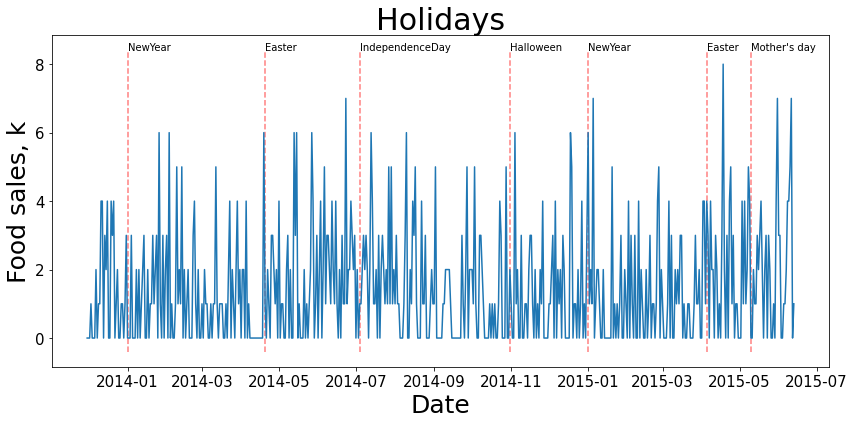

In [188]:
holidaysShow(products_sales[0])

### SNAP - Supplemental Nutrition Assistance Program

In [190]:
snap=calendar.drop(columns=['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1',
                           'event_type_1', 'event_name_2', 'event_type_2'])
snap['date']=pd.to_datetime(snap['date'])
snap.set_index('date', inplace=True)

snap['snap_CA'] = snap['snap_CA'].astype('float')
snap['snap_TX'] = snap['snap_TX'].astype('float')
snap['snap_WI'] = snap['snap_WI'].astype('float')

snap.head()

,snap_CA,snap_TX,snap_WI
date,,,
2011-01-29,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0
2011-01-31,0.0,0.0,0.0
2011-02-01,1.0,1.0,0.0
2011-02-02,1.0,0.0,1.0


In [191]:
def showSnap():
    fig, ax = plt.subplots(nrows=1, figsize=(16,12))
    calmap.yearplot(snap.snap_CA, year=2015, ax=ax)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.xaxis.set_tick_params(labelsize=15)

    plt.tight_layout()
    plt.show()

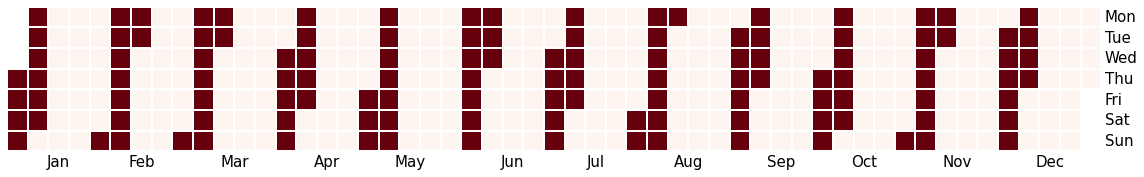

In [192]:
showSnap()

In [194]:
to_concat = list()
names = list()
for i, d in enumerate(products_sales):
    to_concat.append(pd.DataFrame(d.sales))
    names.append("Product "+str(i))
    
sales = pd.concat(to_concat, axis=1)
sales.columns = names
sales.head()

,Product 0,Product 1,Product 2,Product 3,Product 4
date,,,,,
2011-01-29,0.0,4.0,17.0,5.0,0.0
2011-01-30,0.0,1.0,3.0,1.0,1.0
2011-01-31,3.0,0.0,8.0,1.0,0.0
2011-02-01,1.0,1.0,2.0,1.0,11.0
2011-02-02,7.0,4.0,5.0,3.0,1.0


In [195]:
weekday_features=calendar.drop(columns=['wm_yr_wk', 'wday', 'd', 'month', 'year', 'event_name_2', 'event_name_1',
                           'event_type_2', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI'])
weekday_features['date']=pd.to_datetime(weekday_features['date'])
weekday_features.set_index('date', inplace=True)

weekday_features['is_saturday'] = weekday_features['weekday'] == 'Saturday'
weekday_features['is_saturday'] = weekday_features['is_saturday'].astype('float')

weekday_features['is_sunday'] = weekday_features['weekday'] == 'Sunday'
weekday_features['is_sunday'] = weekday_features['is_sunday'].astype('float')

weekday_features['is_monday'] = weekday_features['weekday'] == 'Monday'
weekday_features['is_monday'] = weekday_features['is_monday'].astype('float')

weekday_features['is_friday'] = weekday_features['weekday'] == 'Friday'
weekday_features['is_friday'] = weekday_features['is_friday'].astype('float')

weekday_features.drop(columns=['weekday'], inplace=True)
weekday_features.head()

,is_saturday,is_sunday,is_monday,is_friday
date,,,,
2011-01-29,1.0,0.0,0.0,0.0
2011-01-30,0.0,1.0,0.0,0.0
2011-01-31,0.0,0.0,1.0,0.0
2011-02-01,0.0,0.0,0.0,0.0
2011-02-02,0.0,0.0,0.0,0.0


In [196]:
events_features=calendar.drop(columns=['wm_yr_wk', 'weekday', 'year', 'd', 'wday', 'month',
                                       'snap_CA', 'snap_TX', 'snap_WI'])
events_features['date']=pd.to_datetime(events_features['date'])

events_features['is_day_off'] = (events_features.date.dt.day == 25) & (events_features.date.dt.month == 12)
events_features['is_day_off'] = events_features['is_day_off'].astype('float')

events_features.set_index('date', inplace=True)

events_features['is_sporting'] = (events_features.event_type_1 == 'Sporting') | (events_features.event_type_2 == 'Sporting')
events_features['is_sporting'] = events_features['is_sporting'].astype('float')

events_features['is_cultural'] = (events_features.event_type_1 == 'Cultural') | (events_features.event_type_2 == 'Cultural')
events_features['is_cultural'] = events_features['is_cultural'].astype('float')

events_features['is_national'] = (events_features.event_type_1 == 'National') | (events_features.event_type_2 == 'National')
events_features['is_national'] = events_features['is_national'].astype('float')

events_features['is_religious'] = (events_features.event_type_1 == 'Religious') | (events_features.event_type_2 == 'Religious')
events_features['is_religious'] = events_features['is_religious'].astype('float')

events_features.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], inplace=True)

events_features.head()

,is_day_off,is_sporting,is_cultural,is_national,is_religious
date,,,,,
2011-01-29,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0,0.0,0.0
2011-01-31,0.0,0.0,0.0,0.0,0.0
2011-02-01,0.0,0.0,0.0,0.0,0.0
2011-02-02,0.0,0.0,0.0,0.0,0.0


In [197]:
tomorrow_features = events_features.reset_index()

tomorrow_features.date = tomorrow_features.date - timedelta(days=1)
tomorrow_features.drop(tomorrow_features.head(1).index, inplace=True)

last=tomorrow_features.loc[1]
last.date=tomorrow_features.loc[len(tomorrow_features)].date + timedelta(days=1)
tomorrow_features.loc[len(tomorrow_features)+1]=last
tomorrow_features.loc[len(tomorrow_features)].date=date

tomorrow_features.set_index('date', inplace=True)
tomorrow_features.columns = tomorrow_features.columns + '_tomorrow'

tomorrow_features.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


,is_day_off_tomorrow,is_sporting_tomorrow,is_cultural_tomorrow,is_national_tomorrow,is_religious_tomorrow
date,,,,,
2011-01-29,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0,0.0,0.0
2011-01-31,0.0,0.0,0.0,0.0,0.0
2011-02-01,0.0,0.0,0.0,0.0,0.0
2011-02-02,0.0,0.0,0.0,0.0,0.0


In [198]:
collection = pd.concat([sales, weekday_features, events_features, tomorrow_features, snap], axis=1).dropna()
collection.rename(columns={'snap_CA': 'is_discount'}, inplace=True)
collection.head()

,Product 0,Product 1,Product 2,Product 3,Product 4,is_saturday,is_sunday,is_monday,is_friday,is_day_off,...,is_national,is_religious,is_day_off_tomorrow,is_sporting_tomorrow,is_cultural_tomorrow,is_national_tomorrow,is_religious_tomorrow,is_discount,snap_TX,snap_WI
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0.0,4.0,17.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.0,1.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-31,3.0,0.0,8.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-01,1.0,1.0,2.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2011-02-02,7.0,4.0,5.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [199]:
def showCorrelationDays():
    fig, axes = plt.subplots(figsize=(15,8))

    ind=pd.Index([*names, 'is_saturday',
       'is_sunday', 'is_monday', 'is_friday', 'is_day_off', 'is_discount'])

    sns.heatmap(collection[ind].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Correlation of target and features', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target: ", *names)

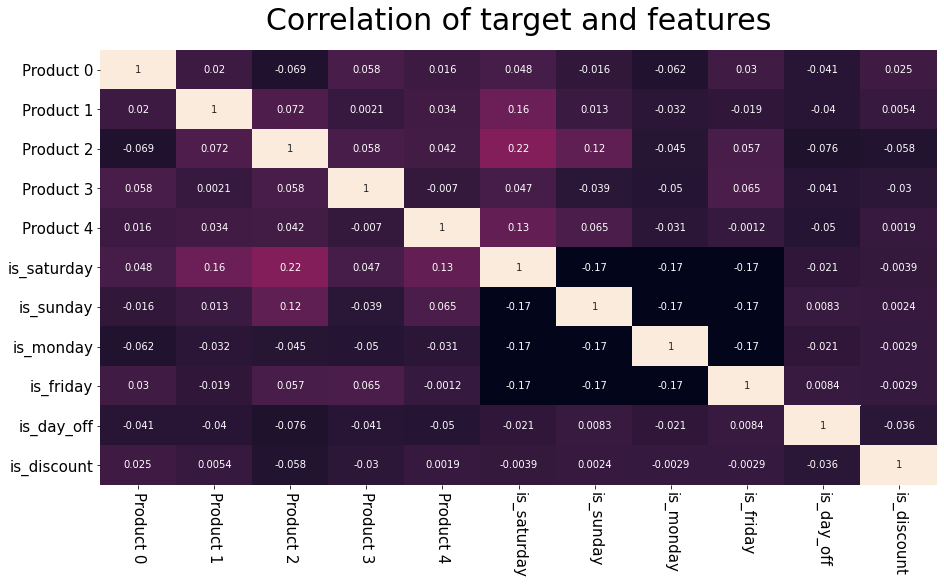

Target:  Product 0 Product 1 Product 2 Product 3 Product 4


In [200]:
showCorrelationDays()

In [201]:
def showCorrelationEvents():
    fig, axes = plt.subplots(figsize=(15,8))

    ind=pd.Index([*names, 'is_sporting', 'is_cultural',
                  'is_national', 'is_religious', 'is_sporting_tomorrow', 'is_cultural_tomorrow',
                  'is_national_tomorrow', 'is_religious_tomorrow'])

    sns.heatmap(collection[ind].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Correlation of target and features', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target:", *names)

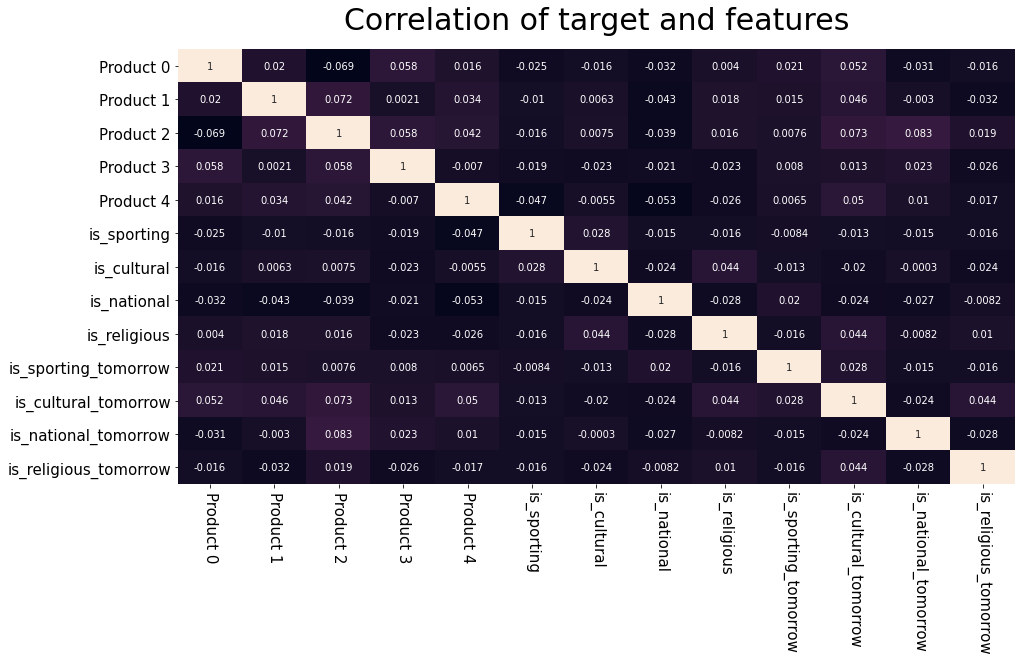

Target: Product 0 Product 1 Product 2 Product 3 Product 4


In [202]:
showCorrelationEvents()

In [203]:
features_columns = ['is_saturday', 'is_sunday', 'is_monday', 'is_friday', 'is_day_off', \
       'is_sporting', 'is_cultural', 'is_national', 'is_religious', \
       'is_day_off_tomorrow', 'is_sporting_tomorrow', 'is_cultural_tomorrow', \
       'is_national_tomorrow', 'is_religious_tomorrow', 'is_discount']

In [207]:
products_sales_with_features = list()
for i, _ in enumerate(products_sales):
    products_sales_with_features.append(pd.concat([products_sales[i], collection[features_columns]], axis=1))

In [209]:
products_sales_with_features[0].head()

,sales,is_saturday,is_sunday,is_monday,is_friday,is_day_off,is_sporting,is_cultural,is_national,is_religious,is_day_off_tomorrow,is_sporting_tomorrow,is_cultural_tomorrow,is_national_tomorrow,is_religious_tomorrow,is_discount
date,,,,,,,,,,,,,,,,
2011-01-29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-31,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-02-02,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [408]:
best_models_with_features_list = model_lists_f(model_lists, model_grids, products_sales_with_features, lags)

RMSE metric of fitting on train


,Product 1,Product 2,Product 3,Product 4,Product 5
DecisionTree,1.843,1.593,5.573,1.377,1.809
RandomForest,0.941,0.857,2.459,0.625,0.861
GradientBoosting,1.808,1.575,5.268,1.354,1.756


RMSE metric of prediction for test


,Product 1,Product 2,Product 3,Product 4,Product 5
DecisionTree,1.592,1.174,7.046,1.166,1.857
RandomForest,1.755,1.295,6.529,1.005,1.855
GradientBoosting,1.612,1.140,6.992,1.045,1.774


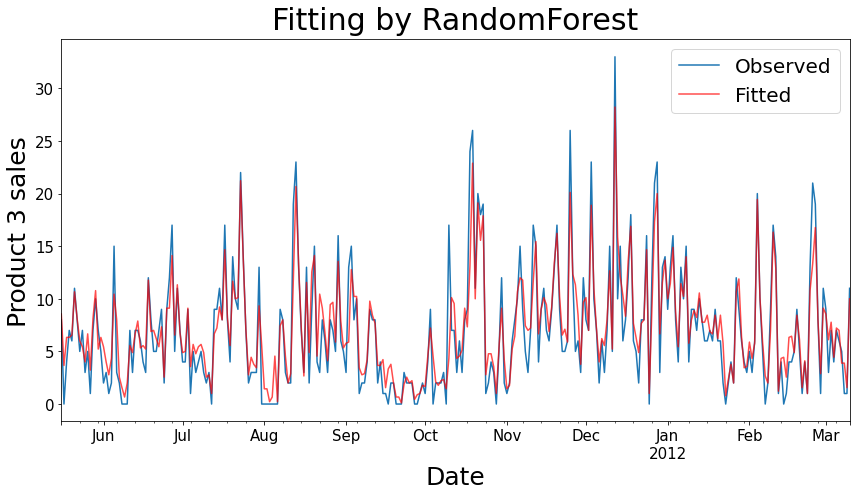

RMSE: 2.45854


In [467]:
fittingShow(best_models_with_features_list[1], products_sales_with_features, lags, index=2)

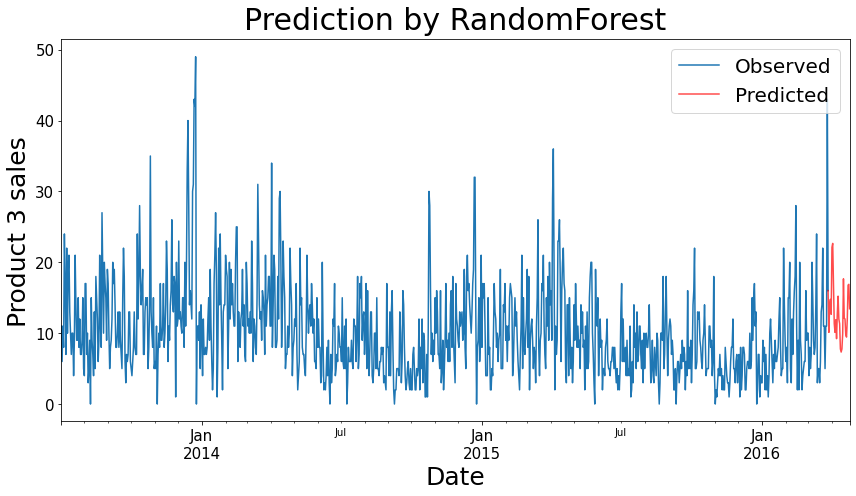

In [466]:
estimationShow(best_models_with_features_list[1], products_sales_with_features, lags, index=2)

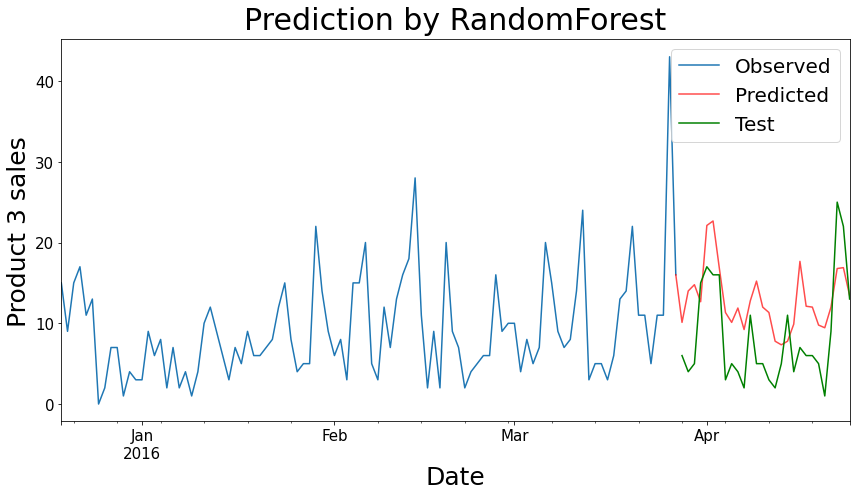

In [465]:
estimationCompare(best_models_with_features_list[1], products_sales_with_features, lags, index=2)

# Prediction

In [ ]:
food_future=food_model.predict(start=1885, end=1884+28)
food_future=pd.DataFrame(food_future, columns=['future'])
food_comparison=pd.concat([food_future, test_set.food], axis=1)
food_comparison.rename(columns={'food':'sales'}, inplace=True)
food_comparison.future[0]=food_comparison.sales[0]
food_comparison.head()

In [ ]:
def compareFitting(data, models, titles):
    fig, axes = plt.subplots(nrows=2,figsize=(12,8))

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=10)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    ind = np.arange(100,400)
    (data/1000)[ind].plot(ax=axes[0])
    (data/1000)[ind].plot(ax=axes[1])
    (models[0].fittedvalues/1000)[ind].plot(ax=axes[0],color='r', alpha=0.7)
    (models[1].fittedvalues/1000)[ind].plot(ax=axes[1],color='r', alpha=0.7)

    axes[0].set_ylabel('Sales, k', fontsize=25)
    axes[0].set_xlabel('Date', fontsize=25)
    axes[1].set_ylabel('Sales, k', fontsize=25)
    axes[1].set_xlabel('Date', fontsize=25)

    axes[0].legend(['Observed', 'Fitted'], fontsize=20, loc='lower left')
    axes[1].legend(['Observed', 'Fitted'], fontsize=20, loc='lower left')

    plt.tight_layout()
    plt.show()
    
    print('SMAPE: %.5f%% vs %.5f%%' % (smape(data, models[0].fittedvalues),smape(data, models[1].fittedvalues)))

In [ ]:
def residuesCompare(models, titles):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=20)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=20)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    (models[0].resid/1000).plot(ax=axes[0], legend=False)
    (models[1].resid/1000).plot(ax=axes[1], legend=False)

    ylabelsize=20
    axes[0].set_ylabel('Residue, k', fontsize=ylabelsize)
    axes[0].set_xlabel('Date', fontsize=0)
    axes[1].set_ylabel('Residue, k', fontsize=ylabelsize)
    axes[1].set_xlabel('Date', fontsize=0)

    plt.tight_layout()
    plt.show()

    p_stud1=stats.ttest_1samp(models[0].resid, 0)[1]
    p_stud2=stats.ttest_1samp(models[1].resid, 0)[1]
    p_adf1=sm.tsa.stattools.adfuller(models[0].resid)[1]
    p_adf2=sm.tsa.stattools.adfuller(models[1].resid)[1]

    print("Student's test: p=%.5f vs p=%.5f"% (p_stud1,p_stud2))
    print("Dickey–Fuller test: p=%s vs p=%s"% ("{:e}".format(p_adf1),"{:e}".format(p_adf2)))
    

In [ ]:
def autocorrelationCompare(models, titles):
    fig, axes = plt.subplots(nrows=2,figsize=(12,9))

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)
    
    sm.graphics.tsa.plot_acf(models[0].resid.values.squeeze(), lags=800, ax=axes[0], markersize=4, title='')
    axes[0].set_ylabel('Autocorrelation', fontsize=25)
    sm.graphics.tsa.plot_acf(models[1].resid.values.squeeze(), lags=800, ax=axes[1], markersize=4, title='')
    axes[1].set_ylabel('Autocorrelation', fontsize=25)

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=10)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def predictionsCompare(data, predictions, titles):
    fig, axes = plt.subplots(nrows=2,figsize=(12,9))

    axes[0].set_title(titles[0], fontdict={'fontsize':30}, pad=10)
    axes[1].set_title(titles[1], fontdict={'fontsize':30}, pad=10)

    labelsize=15
    axes[0].yaxis.set_tick_params(labelsize=labelsize)
    axes[0].xaxis.set_tick_params(labelsize=labelsize)
    axes[1].yaxis.set_tick_params(labelsize=labelsize)
    axes[1].xaxis.set_tick_params(labelsize=labelsize)

    (data/1000)[-100:].plot(ax=axes[0])
    (predictions[0].future/1000).plot(ax=axes[0],color='r', alpha=0.7)
    (predictions[0].sales/1000).plot(ax=axes[0],color='g')

    (data/1000)[-100:].plot(ax=axes[1])
    (predictions[1].future/1000).plot(ax=axes[1],color='r', alpha=0.7)
    (predictions[1].sales/1000).plot(ax=axes[1],color='g')

    axes[0].set_ylabel('Sales, k', fontsize=25)
    axes[0].set_xlabel('Date', fontsize=25)
    axes[1].set_ylabel('Sales, k', fontsize=25)
    axes[1].set_xlabel('Date', fontsize=25)

    axes[0].legend(['Observed','Predicted', 'Test'], fontsize=20, loc='lower right')
    axes[1].legend(['Observed','Predicted', 'Test'], fontsize=20, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    smape1 = smape(predictions[0].sales[1:],predictions[0].future[1:])
    smape2 = smape(predictions[1].sales[1:],predictions[1].future[1:])
    print('SMAPE = %.5f%% vs %.5f%%' % (smape1, smape2))

In [ ]:
compareFitting(train.food, (food_model,food_model_exog_days), ('Food model fitting','Exog: days'))

In [ ]:
residuesCompare((food_model,food_model_exog_days),('Food residues','Food residues, Exog: days'))

In [ ]:
autocorrelationCompare((food_model,food_model_exog_days),('Food residues autocorrelation','With exog: days'))

In [ ]:
food_future_exog_days=food_model_exog_days.predict(start=1885, end=1884+28, exog=exog_days_test)
food_future_exog_days=pd.DataFrame(food_future_exog_days, columns=['future'])
food_comparison_exog_days=pd.concat([food_future_exog_days, test_set.food], axis=1)
food_comparison_exog_days.rename(columns={'food':'sales'}, inplace=True)
food_comparison_exog_days.future[0]=food_comparison_exog_days.sales[0]
food_comparison_exog_days.head()

In [ ]:
predictionsCompare(train.food, (food_comparison, food_comparison_exog_days), ('Food sales prediction','With exog=days'))

# Results

In [ ]:
# ARIMA:
a1="%.2f" % (smape(food_comparison.sales[1:],food_comparison.future[1:]))
a2="%.2f" % (smape(hobbies_comparison.sales[1:],hobbies_comparison.future[1:]))
a3="%.2f" % (smape(household_comparison.sales[1:],household_comparison.future[1:]))

# ARIMA + days
b1="%.2f" % (smape(food_comparison_exog_days.sales[1:],food_comparison_exog_days.future[1:]))
b2="%.2f" % (smape(hobbies_comparison_exog_days.sales[1:],hobbies_comparison_exog_days.future[1:]))
b3="%.2f" % (smape(household_comparison_exog_days.sales[1:],household_comparison_exog_days.future[1:]))

# ARIMA + events
c1="%.2f" % (smape(food_comparison_exog_events.sales[1:],food_comparison_exog_events.future[1:]))
c2="%.2f" % (smape(hobbies_comparison_exog_events.sales[1:],hobbies_comparison_exog_events.future[1:]))
c3="%.2f" % (smape(household_comparison_exog_events.sales[1:],household_comparison_exog_events.future[1:]))

# ARIMA + snap
d1="%.2f" % (smape(food_comparison_exog_snap.sales[1:],food_comparison_exog_snap.future[1:]))
d2="%.2f" % (smape(hobbies_comparison_exog_snap.sales[1:],hobbies_comparison_exog_snap.future[1:]))
d3="%.2f" % (smape(household_comparison_exog_snap.sales[1:],household_comparison_exog_snap.future[1:]))

statistics={'pure ARIMA' : [a1, a2, a3], 'exog=days' : [b1, b2, b3],
           'exog=events' : [c1, c2, c3], 'exog=snap' : [d1, d2, d3]}

statistics=pd.DataFrame(statistics, index=('food','hobbies','household'), columns=('pure ARIMA',
                                                            'exog=days', 'exog=events','exog=snap'))
statistics = statistics + '%'

statistics

In [ ]:
boldList = ('2.66%', '2.83%', '2.37%', '2.46%', '2.80%')

def makeBold(x):
    if x in boldList:
        return 'font-weight: bold'
    else:
        return ''

statForPrint=statistics.style.applymap(makeBold)

In [ ]:
def showResults():

    print('Metrics: SMAPE')
    
    return statForPrint

In [ ]:
showResults()

In [ ]:
Image(filename='lol.jpg')